In [1]:
from dotenv import load_dotenv
from tqdm import tqdm
import os, re

from hsg.featureanalysis.regelementcorr import read_bed_file, get_sequences_from_dataframe
from hsg.stattools.features import get_latent_model

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from biocommons.seqrepo import SeqRepo

load_dotenv()  # take environment variables from .env file

Importing Goodies...


/home/ek224/anaconda3/envs/hsg/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/ek224/anaconda3/envs/hsg/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/ek224/anaconda3/envs/hsg/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings

True

In [2]:
cisplat_binding_sites = read_bed_file("data/Nair_cisplatin_oct_25/RNAs/cisplatin_binding_sites.bed", max_columns=6)
print(cisplat_binding_sites)

100%|██████████| 11795/11795 [00:00<00:00, 1577998.01it/s]

       chrom  chromStart   chromEnd               name   score strand
0      chr12    65824760   65824860  ENSG00000149948-4  1000.0      +
1      chr12    65824560   65824660  ENSG00000149948-2  1000.0      +
2       chr4   104491549  104491649  ENSG00000245384-1  1000.0      +
3       chr4   104491908  104492008  ENSG00000168772-9  1000.0      -
4       chr5   126777323  126777423  ENSG00000113368-2  1000.0      +
...      ...         ...        ...                ...     ...    ...
11790   chr1    15765007   15765107  ENSG00000162458-1  1000.0      +
11791  chr15    48178132   48178232  ENSG00000104177-5  1000.0      -
11792  chr10    93702383   93702483  ENSG00000148690-1  1000.0      -
11793   chr1   173733741  173733841  ENSG00000076321-2  1000.0      +
11794  chr17    39402193   39402293  ENSG00000266469-1  1000.0      +

[11795 rows x 6 columns]


In [3]:
cisplat_seqs = get_sequences_from_dataframe(
    seqrepo=SeqRepo(os.getenv("SEQREPO_PATH")),
    df=cisplat_binding_sites,
    pad_size=0,
)
cisplat_seqs = list(set(cisplat_seqs))  # unique sequences only
print(f"Number of unique cisplatin binding sequences: {len(cisplat_seqs)}")

Fetching sequences: 100%|██████████| 11795/11795 [00:03<00:00, 2977.22it/s]

Number of unique cisplatin binding sequences: 11536


In [4]:
# Initialize NTv2 model + SAE
exp_factor = 8
layer_idx = 23
sae_path = f"/home/ek224/Hidden-State-Genomics/checkpoints/hidden-state-genomics/ef{exp_factor}/sae/layer_{layer_idx}.pt"
ntsae23 = get_latent_model(os.environ["NT_MODEL"], layer_idx, sae_path=sae_path)
# Freeze the model weights
for param in ntsae23.parameters():
    param.requires_grad = False

In [5]:
import torch
import numpy as np

# Features to visualize
target_features = [6296, 6445, 407, 2558, 4793, 835, 5234, 3378, 7612, 7799, 7949, 1867]

# Select a subset of sequences for visualization
sample_size = min(20, len(cisplat_seqs))
sample_seqs = cisplat_seqs[:sample_size]

print(f"Analyzing {len(target_features)} features across {len(sample_seqs)} sample sequences...")


Analyzing 12 features across 20 sample sequences...


In [6]:
def extract_feature_activations_with_tokens(model, sequences, feature_ids):
    """
    Extract SAE feature activations for specific features across sequences with token information.
    
    Args:
        model: The LatentModel (ntsae23) with loaded SAE
        sequences: List of DNA sequences to analyze
        feature_ids: List of feature indices to extract
        
    Returns:
        tuple: (feature_activations dict, sequence_tokens list)
            - feature_activations: {feature_id: [list of activation arrays per sequence]}
            - sequence_tokens: [list of token lists for each sequence]
    """
    feature_activations = {}
    sequence_tokens = []
    
    model.eval()
    with torch.no_grad():
        # First pass: collect tokens for all sequences
        print("Extracting tokens and activations...")
        for seq in tqdm(sequences, desc="Processing sequences"):
            sae_acts, tokens = model(seq, return_tokens=True)
            # strip special tokens if present i.e. "<CLS>"
            tokens = [i for i in tokens if not re.match(r'^<.*>$', i)]

            
            # Store tokens for this sequence (only need to do once)
            if not sequence_tokens or len(sequence_tokens) < len(sequences):
                sequence_tokens.append(tokens)
            
            # Extract activations for each feature
            for feat_id in feature_ids:
                if feat_id not in feature_activations:
                    feature_activations[feat_id] = []
                
                # Extract activations for this specific feature across all tokens
                # sae_acts shape: [seq_len, num_features]
                feat_acts = sae_acts[:, feat_id].cpu().numpy()
                feature_activations[feat_id].append(feat_acts)
    
    return feature_activations, sequence_tokens


# Extract activations and tokens using the loaded model
feature_activations, sequence_tokens = extract_feature_activations_with_tokens(
    ntsae23, sample_seqs, target_features
)
print(f"Extraction complete! Stored {len(sequence_tokens)} sequence token arrays")


Extracting tokens and activations...


Processing sequences: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]

Extraction complete! Stored 20 sequence token arrays



Generating multi-sequence comparison plots...


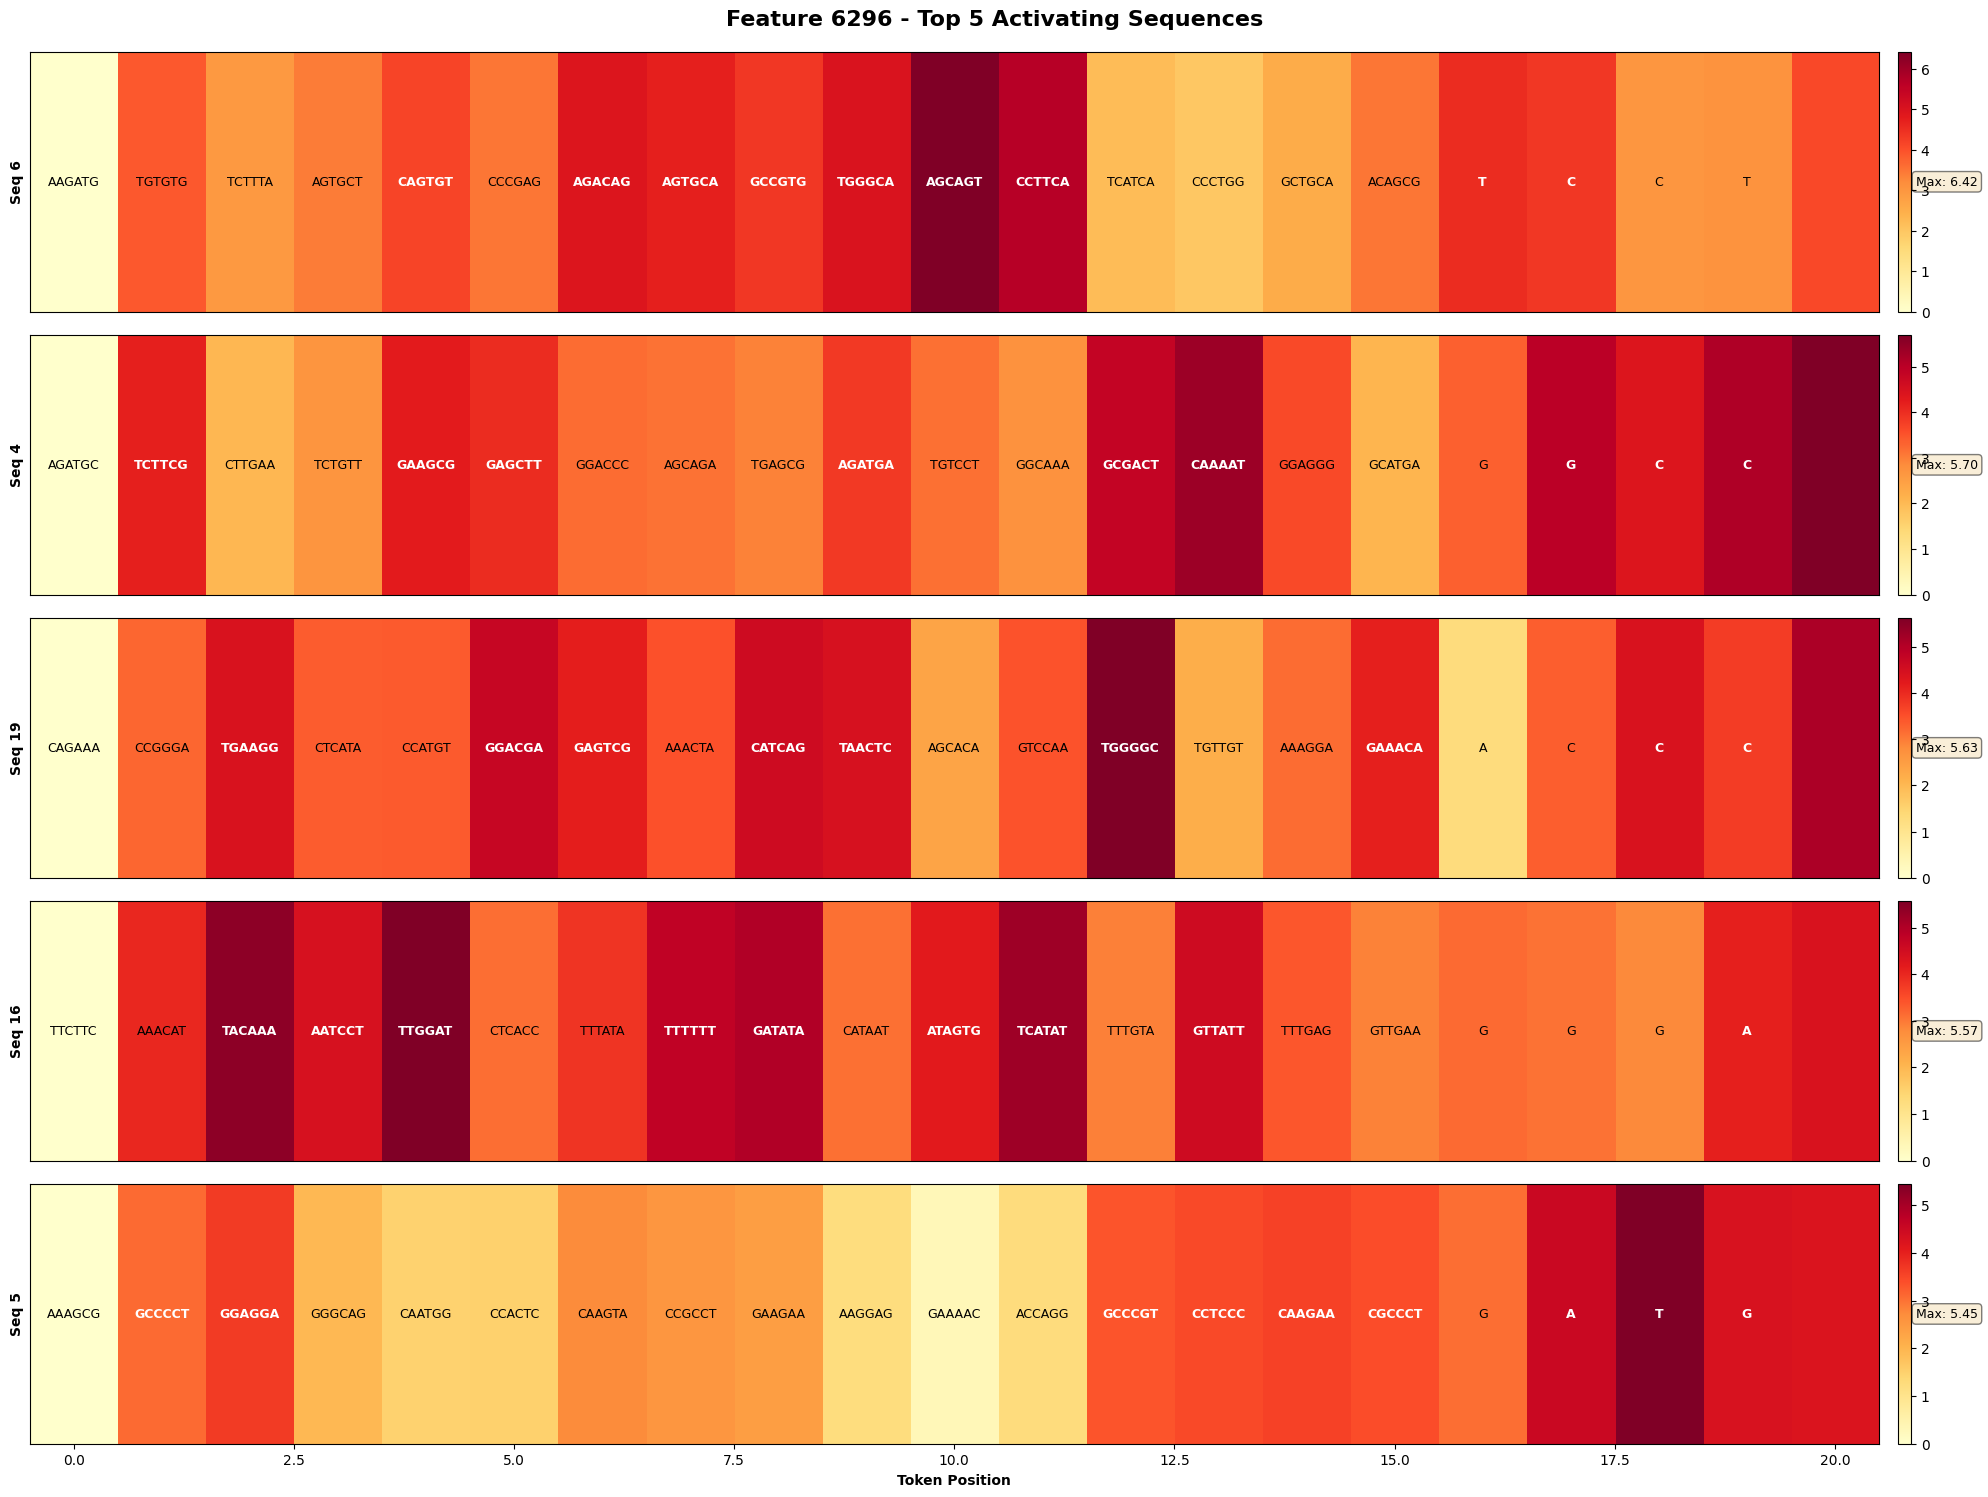

Saved: data/feature_6296_multi_seq_comparison.png


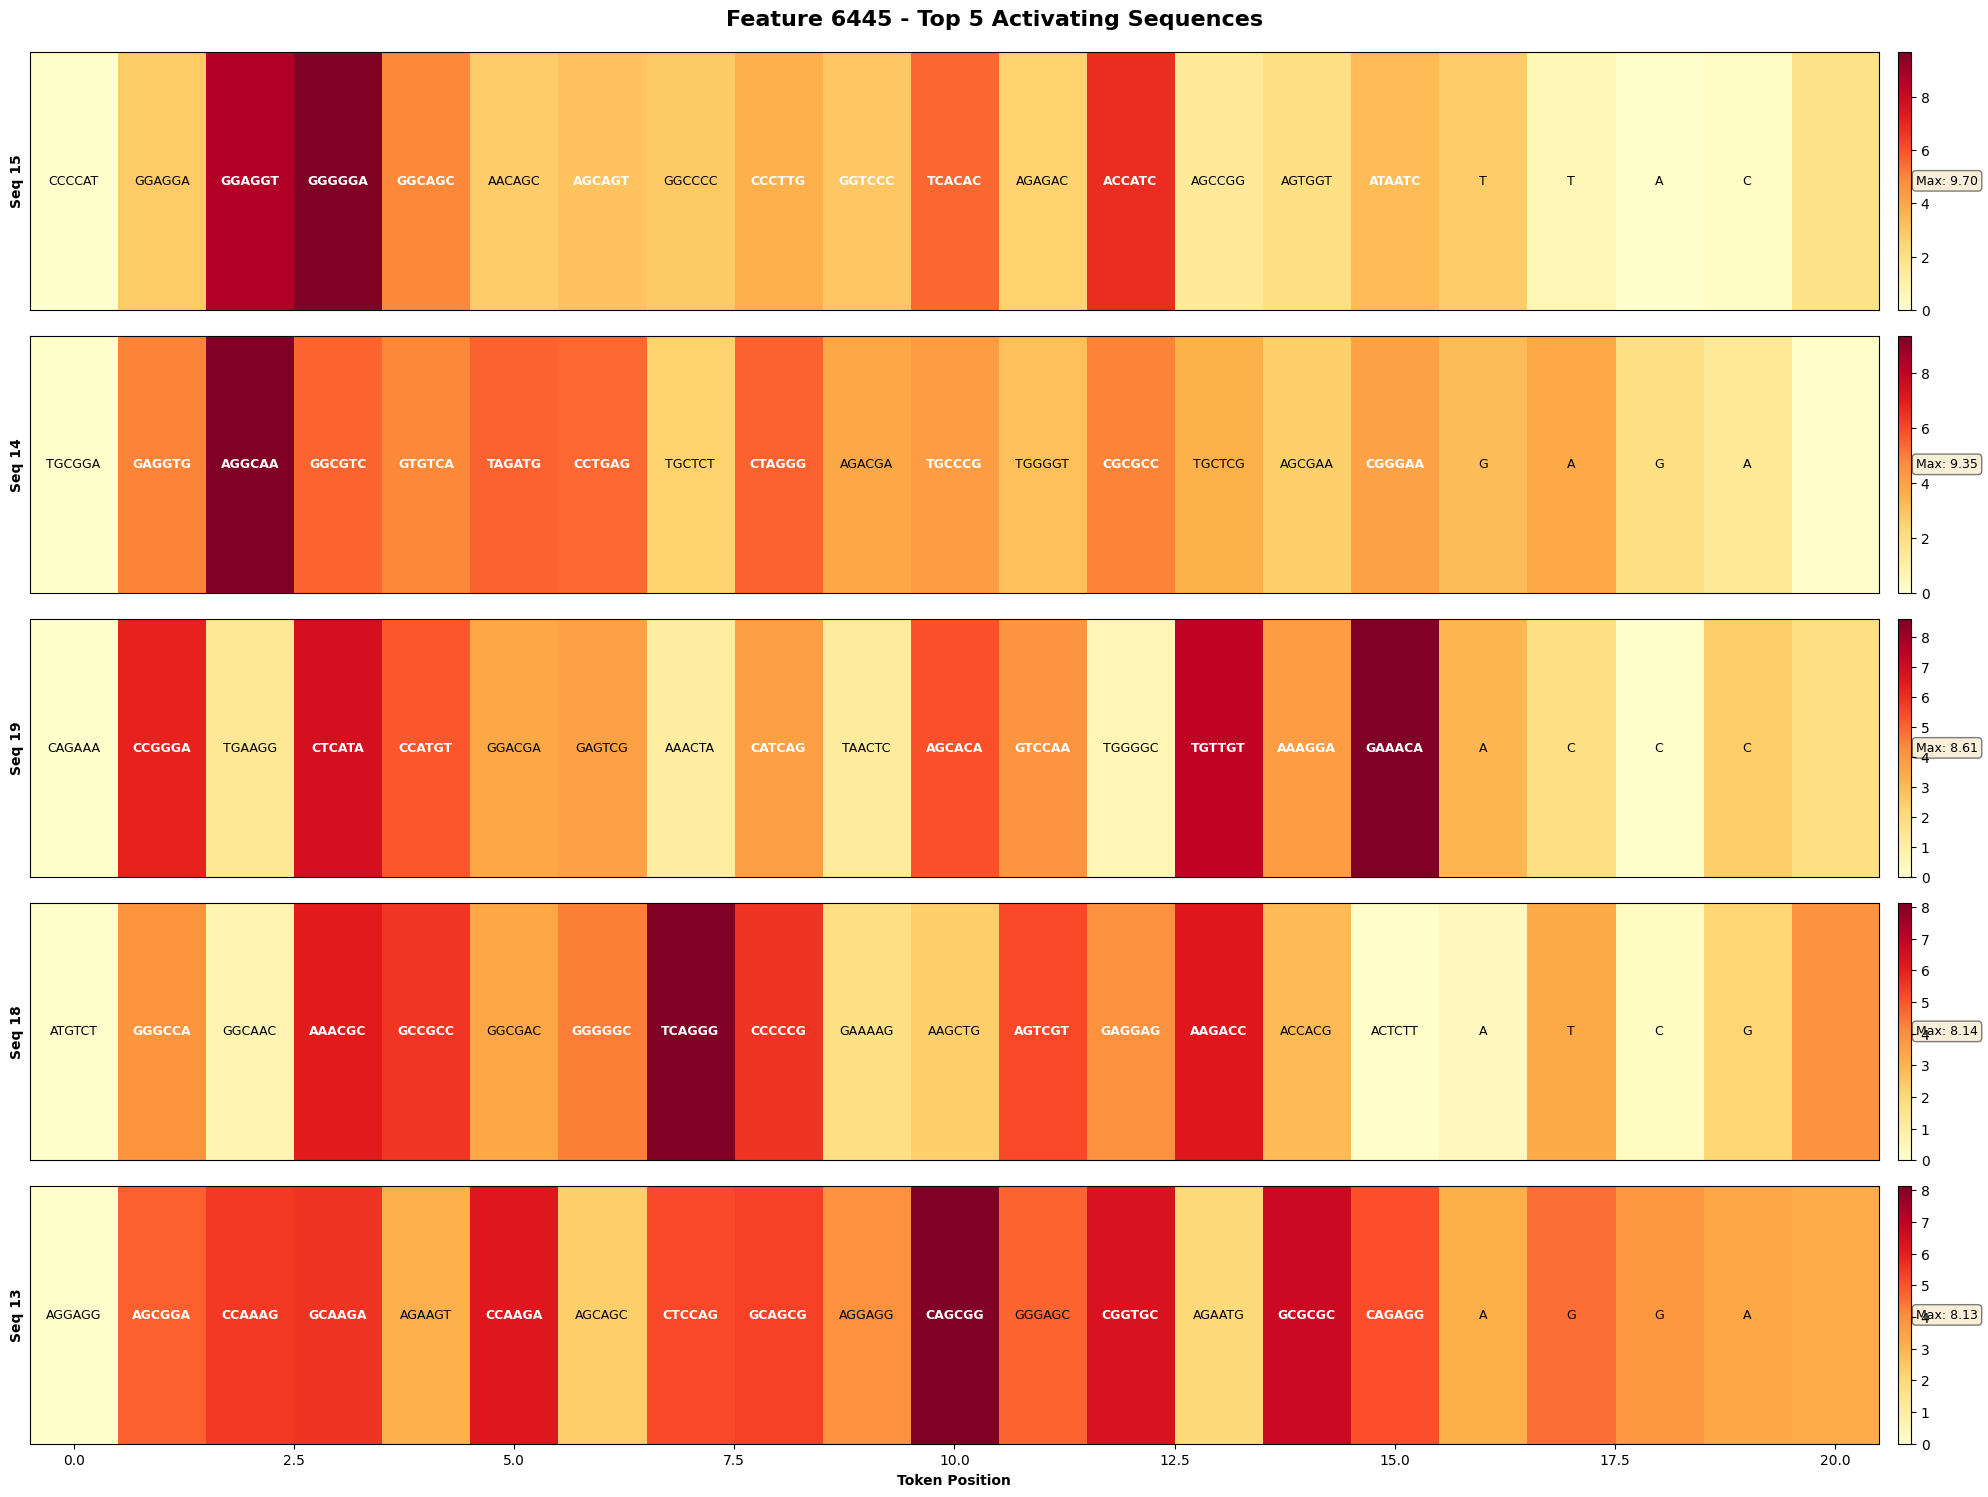

Saved: data/feature_6445_multi_seq_comparison.png


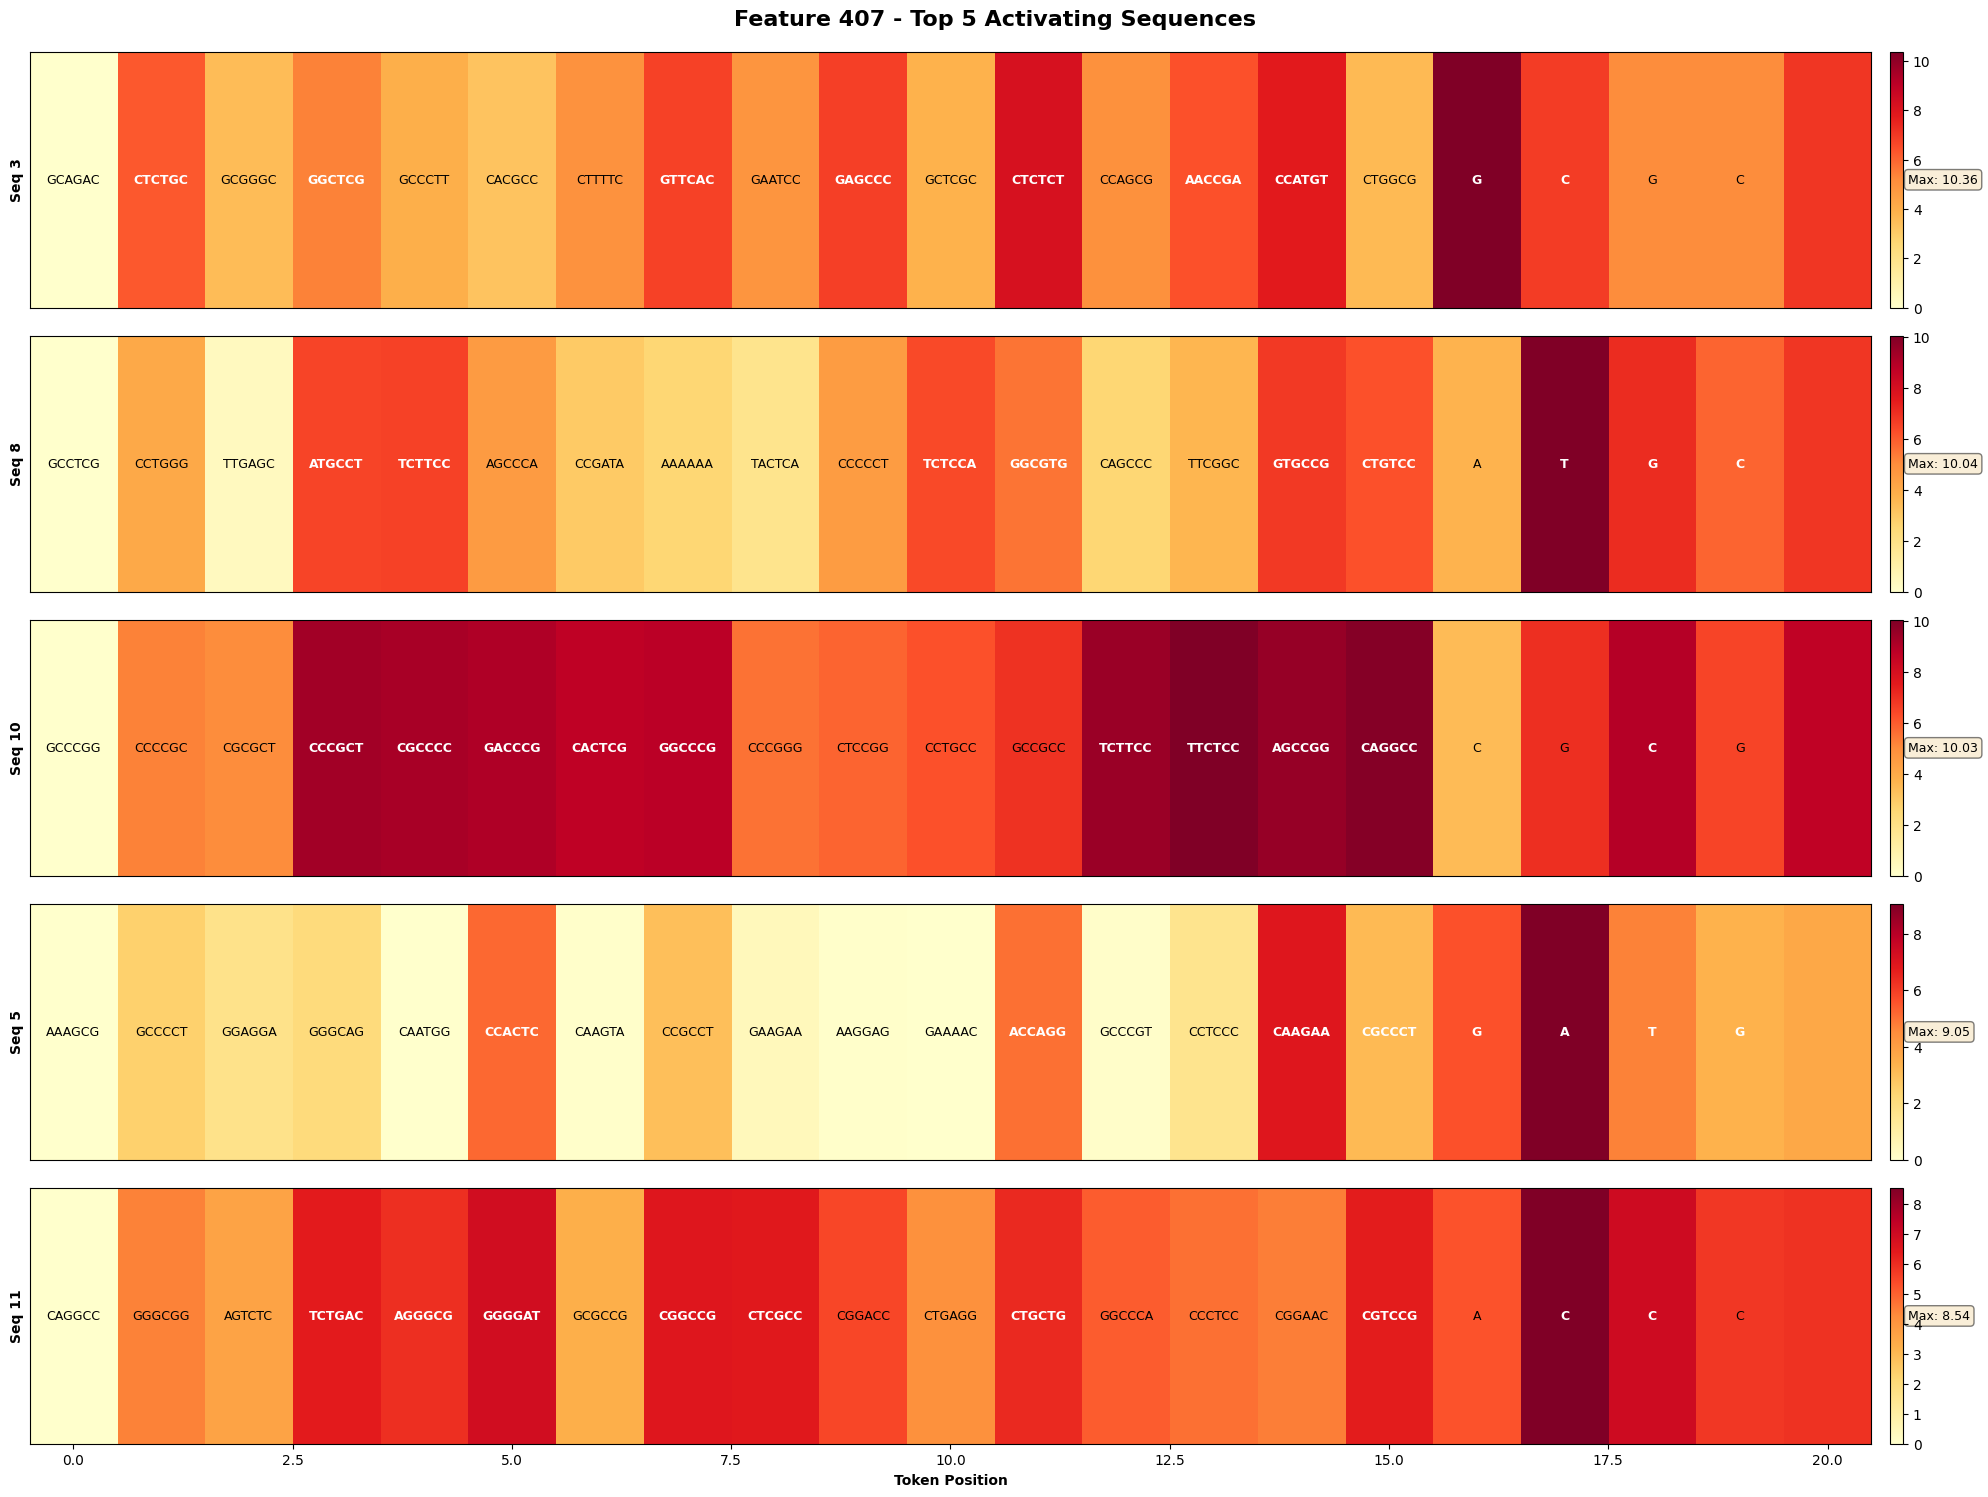

Saved: data/feature_407_multi_seq_comparison.png


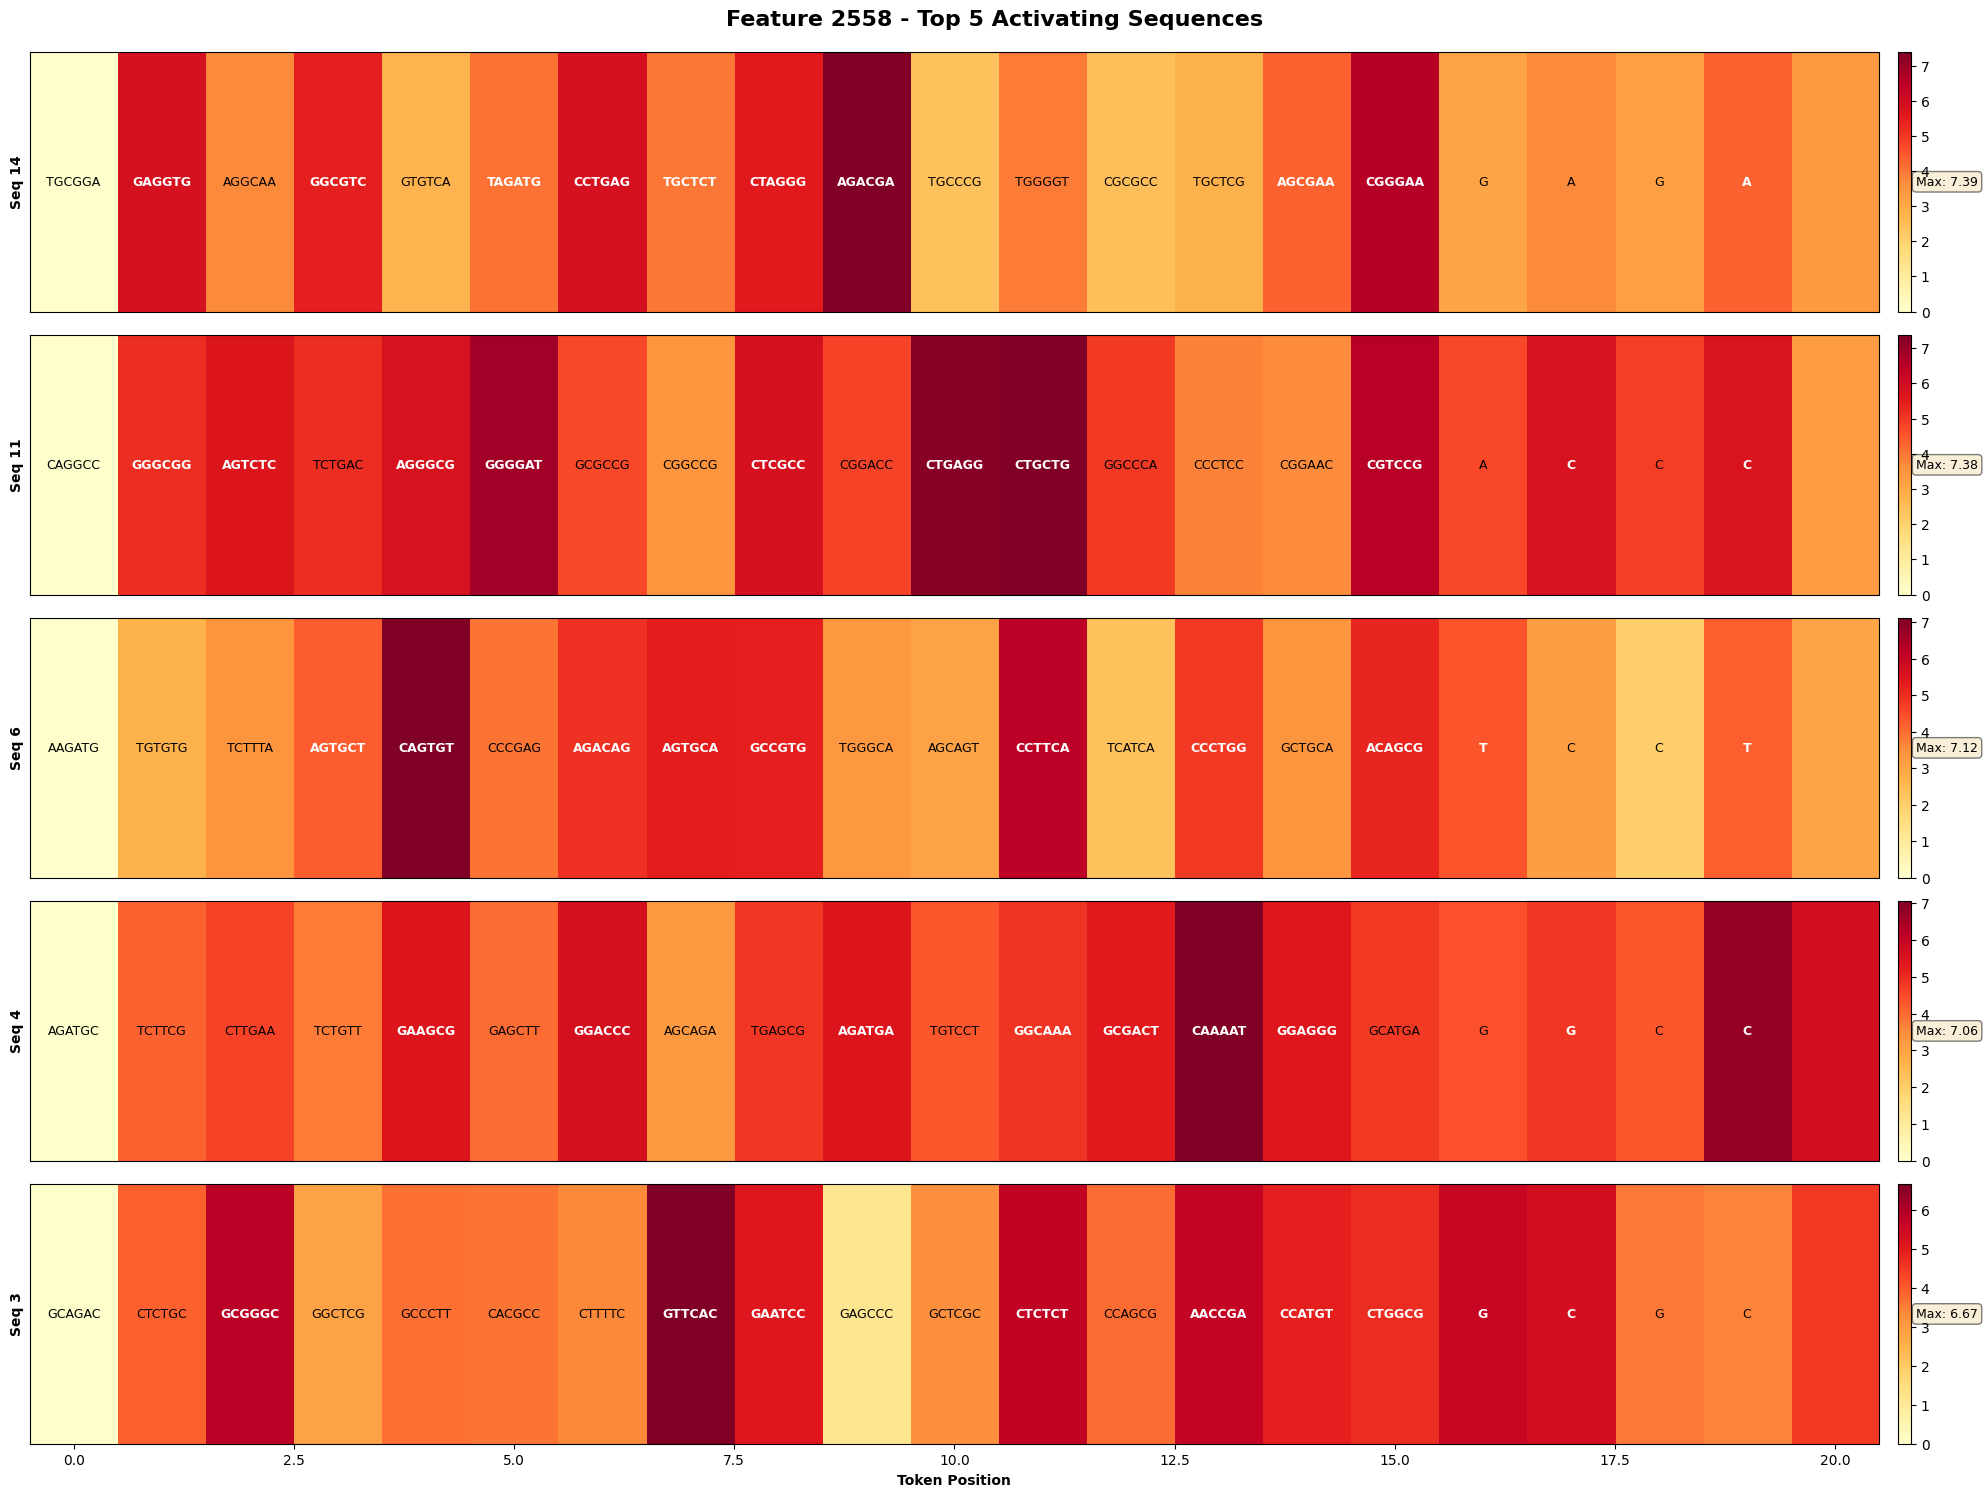

Saved: data/feature_2558_multi_seq_comparison.png


In [7]:
def plot_multi_sequence_comparison(feature_id, feature_activations, sequence_tokens, 
                                   sample_seqs, top_n=5):
    """
    Compare multiple sequences side-by-side for a single feature, showing actual sequences.
    
    Args:
        feature_id: The feature to visualize
        feature_activations: Dict of feature activations
        sequence_tokens: List of token arrays
        sample_seqs: Original sequences
        top_n: Number of top sequences to show
    """
    # Find top activating sequences
    max_acts = [(i, np.max(acts)) for i, acts in enumerate(feature_activations[feature_id])]
    top_seqs = sorted(max_acts, key=lambda x: x[1], reverse=True)[:top_n]
    
    fig, axes = plt.subplots(top_n, 1, figsize=(20, 3*top_n))
    if top_n == 1:
        axes = [axes]
    
    for plot_idx, (seq_idx, max_act) in enumerate(top_seqs):
        ax = axes[plot_idx]
        acts = feature_activations[feature_id][seq_idx]
        tokens = sequence_tokens[seq_idx]
        
        # Create activation heatmap background
        act_matrix = np.tile(acts, (3, 1))
        im = ax.imshow(act_matrix, aspect='auto', cmap='YlOrRd', 
                      interpolation='nearest', extent=[-0.5, len(acts)-0.5, 0, 1])
        
        # Overlay sequence tokens
        threshold = np.percentile(acts[acts > 0], 50) if np.any(acts > 0) else 0
        for i, token in enumerate(tokens):
            text_color = 'white' if acts[i] > threshold else 'black'
            font_weight = 'bold' if acts[i] > threshold else 'normal'
            ax.text(i, 0.5, token, ha='center', va='center', 
                   fontsize=9, fontweight=font_weight, color=text_color)
        
        ax.set_xlim(-0.5, len(acts)-0.5)
        ax.set_ylim(0, 1)
        ax.set_ylabel(f'Seq {seq_idx}', fontweight='bold', fontsize=10)
        ax.set_yticks([])
        
        if plot_idx == top_n - 1:
            ax.set_xlabel('Token Position', fontweight='bold')
        else:
            ax.set_xticks([])
        
        # Add colorbar to rightmost side
        plt.colorbar(im, ax=ax, fraction=0.015, pad=0.01)
        
        # Add max activation annotation
        ax.text(1.02, 0.5, f'Max: {max_act:.2f}', transform=ax.transAxes,
               va='center', fontsize=9, bbox=dict(boxstyle='round', 
               facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Feature {feature_id} - Top {top_n} Activating Sequences', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return fig


# Generate multi-sequence comparisons for top features
print("\n" + "="*80)
print("Generating multi-sequence comparison plots...")
print("="*80)

for feat_id in target_features[:4]:  # Top 4 features
    fig = plot_multi_sequence_comparison(feat_id, feature_activations, 
                                         sequence_tokens, sample_seqs, top_n=5)
    plt.savefig(f'data/feature_{feat_id}_multi_seq_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: data/feature_{feat_id}_multi_seq_comparison.png")


In [8]:
def extract_motifs_from_activations(feature_id, feature_activations, sequence_tokens, 
                                    top_n=10, window_size=3, min_activation=0.5):
    """
    Extract k-mer motifs where a feature strongly activates.
    
    Args:
        feature_id: Feature to analyze
        feature_activations: Dict of activations
        sequence_tokens: List of token arrays
        top_n: Number of top motifs to return
        window_size: Size of motif window (in tokens)
        min_activation: Minimum activation threshold
        
    Returns:
        List of (motif, avg_activation, count) tuples
    """
    motif_dict = {}
    
    for seq_idx, acts in enumerate(feature_activations[feature_id]):
        tokens = sequence_tokens[seq_idx]
        
        # Find positions with strong activation
        strong_positions = np.where(acts >= min_activation)[0]
        
        for pos in strong_positions:
            # Extract motif window around this position
            start = max(0, pos - window_size // 2)
            end = min(len(tokens), pos + window_size // 2 + 1)
            
            motif = ''.join(tokens[start:end])
            activation_val = acts[pos]
            
            if motif not in motif_dict:
                motif_dict[motif] = {'activations': [], 'count': 0}
            
            motif_dict[motif]['activations'].append(activation_val)
            motif_dict[motif]['count'] += 1
    
    # Calculate average activations and sort
    motif_stats = []
    for motif, data in motif_dict.items():
        avg_act = np.mean(data['activations'])
        motif_stats.append((motif, avg_act, data['count']))
    
    motif_stats.sort(key=lambda x: x[1] * x[2], reverse=True)  # Sort by avg_act * count
    
    return motif_stats[:top_n]


# Extract and display top motifs for each feature
print("\n" + "="*80)
print("TOP ACTIVATING MOTIFS PER FEATURE")
print("="*80)

motifs_per_feature = {}
for feat_id in target_features:
    motifs = extract_motifs_from_activations(feat_id, feature_activations, 
                                              sequence_tokens, top_n=5, 
                                              window_size=5, min_activation=0.5)
    motifs_per_feature[feat_id] = motifs
    
    print(f"\nFeature {feat_id}:")
    for motif, avg_act, count in motifs:
        print(f"  {motif:15s} | Avg Act: {avg_act:6.3f} | Count: {count:4d}")



TOP ACTIVATING MOTIFS PER FEATURE

Feature 6296:
  CC              | Avg Act:  5.149 | Count:    3
  GA              | Avg Act:  4.656 | Count:    3
  TG              | Avg Act:  4.214 | Count:    3
  CG              | Avg Act:  3.722 | Count:    3
  CCC             | Avg Act:  4.405 | Count:    2

Feature 6445:
  GGAGGAGGAGGTGGGGGAGGCAGCAACAGC | Avg Act:  9.697 | Count:    1
  TGCGGAGAGGTGAGGCAAGGCGTCGTGTCA | Avg Act:  9.351 | Count:    1
  CCCCATGGAGGAGGAGGTGGGGGAGGCAGC | Avg Act:  8.647 | Count:    1
  TGTTGTAAAGGAGAAACAAC | Avg Act:  8.614 | Count:    1
  GGCGACGGGGGCTCAGGGCCCCCGGAAAAG | Avg Act:  8.140 | Count:    1

Feature 407:
  GC              | Avg Act:  6.962 | Count:    2
  CG              | Avg Act:  6.351 | Count:    2
  CCATGTCTGGCGGCG | Avg Act: 10.365 | Count:    1
  CTGTCCATGC      | Avg Act: 10.037 | Count:    1
  GCCGCCTCTTCCTTCTCCAGCCGGCAGGCC | Avg Act: 10.026 | Count:    1

Feature 2558:
  CC              | Avg Act:  4.428 | Count:    3
  TG              | Avg Ac


Generating sequence-level visualizations for top features...


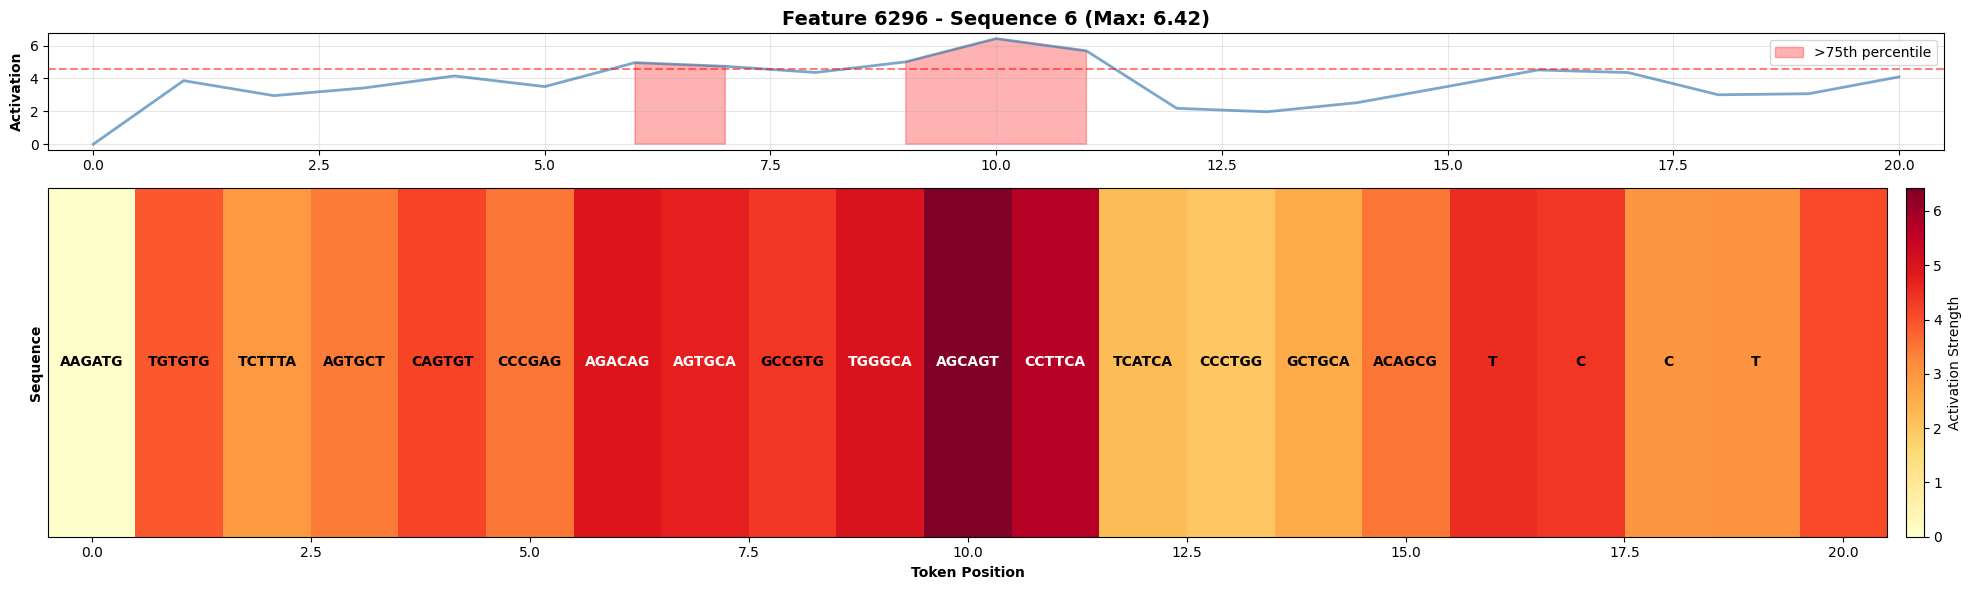

Saved: data/feature_6296_sequence_detail.png


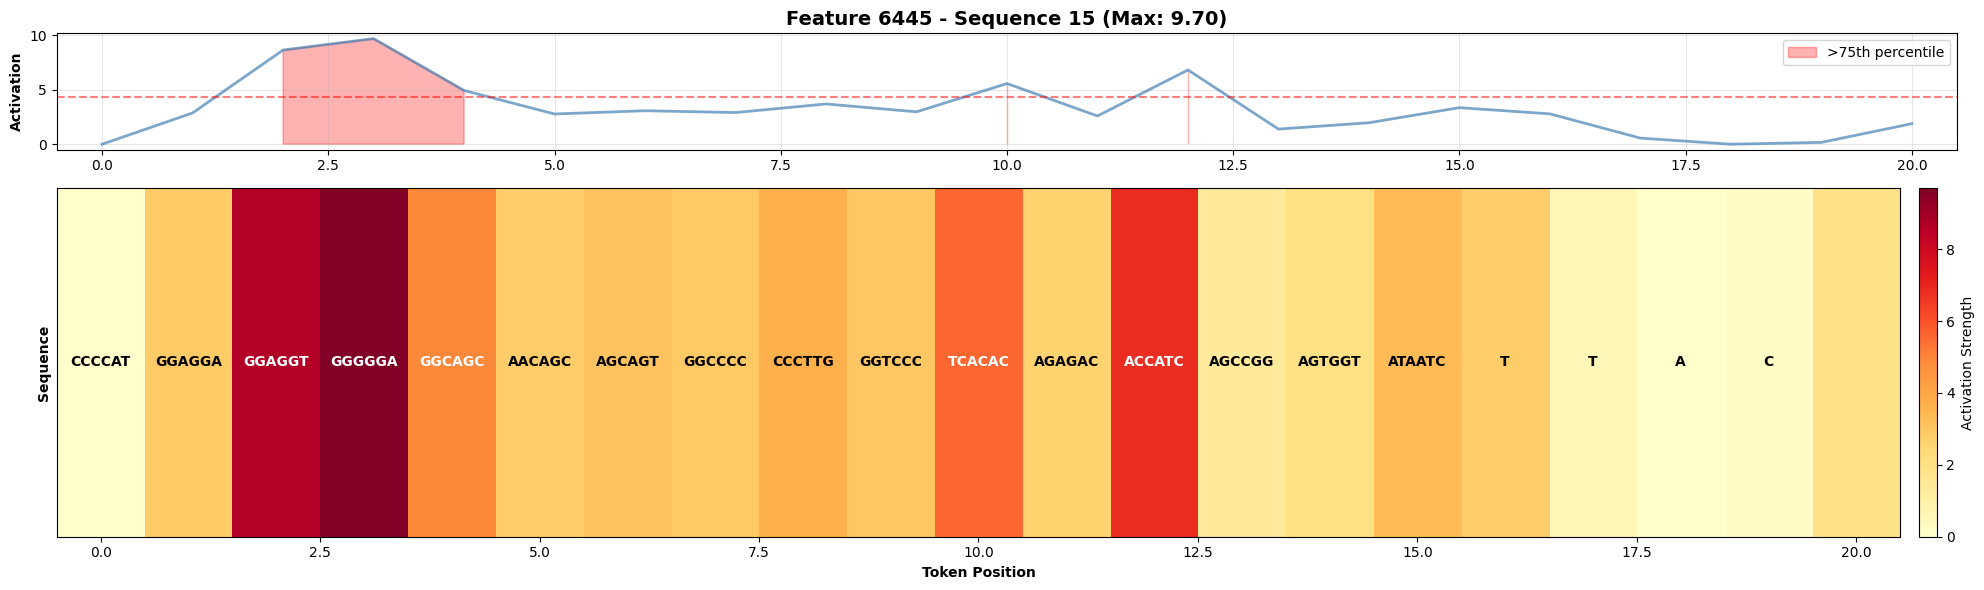

Saved: data/feature_6445_sequence_detail.png


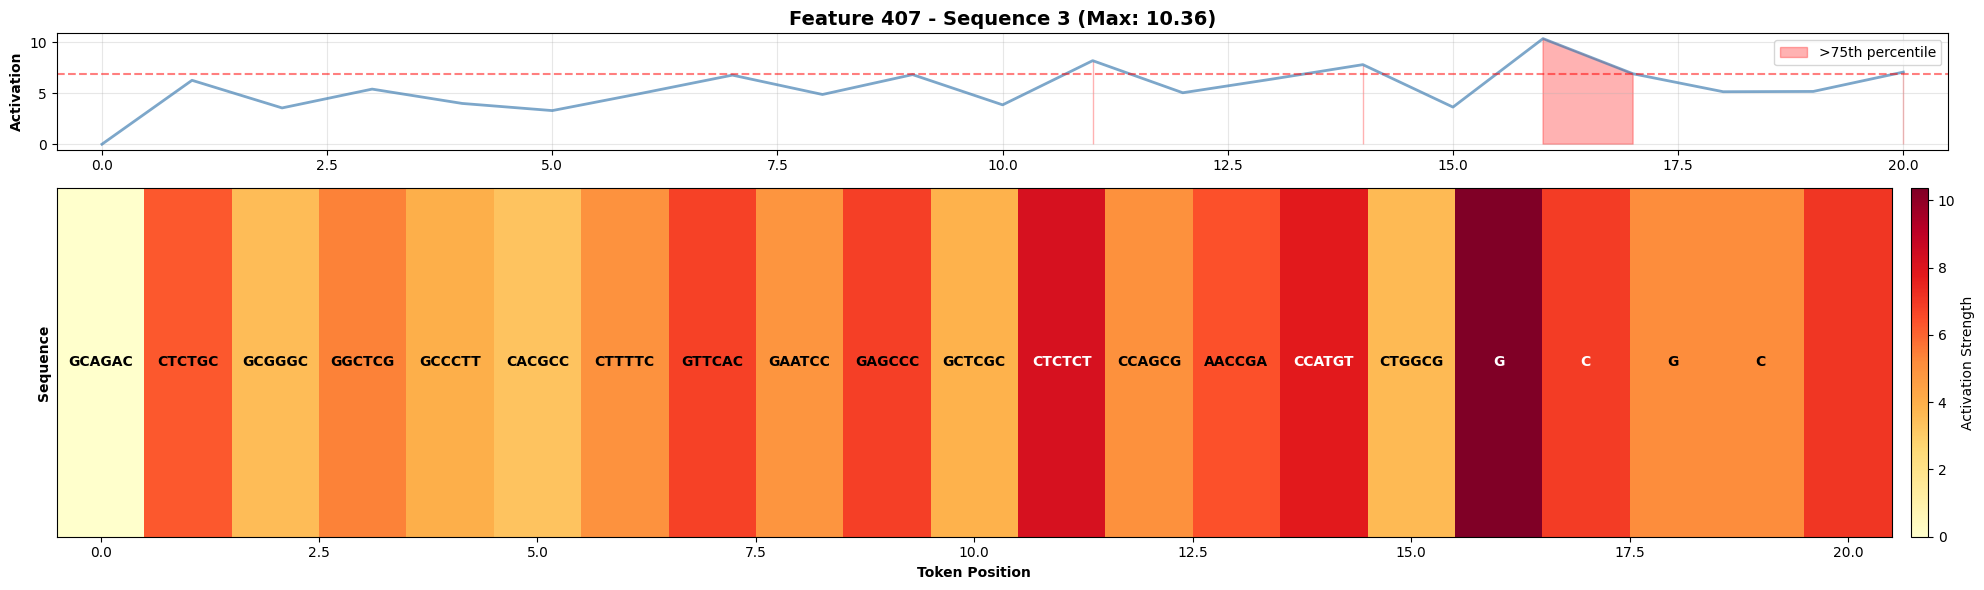

Saved: data/feature_407_sequence_detail.png


In [9]:
def plot_feature_with_sequence(feature_id, seq_idx, feature_activations, sequence_tokens, 
                               sample_seqs, threshold_percentile=75):
    """
    Plot a single feature's activation pattern along with the genomic sequence.
    Shows which nucleotides/motifs the feature activates on.
    
    Args:
        feature_id: The feature to visualize
        seq_idx: Index of the sequence to plot
        feature_activations: Dict of feature activations
        sequence_tokens: List of token arrays
        sample_seqs: List of original sequences
        threshold_percentile: Percentile threshold for highlighting strong activations
    """
    acts = feature_activations[feature_id][seq_idx]
    tokens = sequence_tokens[seq_idx]
    seq = sample_seqs[seq_idx]
    
    # Calculate threshold for "strong" activations
    threshold = np.percentile(acts[acts > 0], threshold_percentile) if np.any(acts > 0) else 0
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), 
                                     gridspec_kw={'height_ratios': [1, 3]})
    
    # Top panel: Activation strength as line plot
    positions = np.arange(len(acts))
    ax1.plot(positions, acts, color='steelblue', linewidth=2, alpha=0.7)
    ax1.fill_between(positions, 0, acts, where=(acts >= threshold), 
                     color='red', alpha=0.3, label=f'>{threshold_percentile}th percentile')
    ax1.axhline(y=threshold, color='red', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Activation', fontweight='bold')
    ax1.set_xlim(-0.5, len(acts)-0.5)
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)
    ax1.set_title(f'Feature {feature_id} - Sequence {seq_idx} (Max: {np.max(acts):.2f})', 
                  fontsize=14, fontweight='bold')
    
    # Bottom panel: Sequence visualization with activation heatmap
    # Create a matrix where each row is the activation value
    act_matrix = np.tile(acts, (5, 1))  # Repeat for visualization height
    
    im = ax2.imshow(act_matrix, aspect='auto', cmap='YlOrRd', 
                    interpolation='nearest', extent=[-0.5, len(acts)-0.5, 0, 1])
    
    # Overlay tokens as text
    for i, token in enumerate(tokens):
        # Color text based on activation strength
        text_color = 'white' if acts[i] > threshold else 'black'
        ax2.text(i, 0.5, token, ha='center', va='center', 
                fontsize=10, fontweight='bold', color=text_color,
                bbox=dict(boxstyle='square,pad=0.1', facecolor='none', 
                         edgecolor='none'))
    
    ax2.set_xlim(-0.5, len(acts)-0.5)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel('Token Position', fontweight='bold')
    ax2.set_yticks([])
    ax2.set_ylabel('Sequence', fontweight='bold')
    
    plt.colorbar(im, ax=ax2, fraction=0.02, pad=0.01, label='Activation Strength')
    plt.tight_layout()
    
    return fig


# Example: Plot the top activating sequence for the first few features
print("\nGenerating sequence-level visualizations for top features...")
for feat_idx, feat_id in enumerate(target_features[:3]):  # First 3 features
    # Find sequence with max activation
    max_acts = [np.max(acts) for acts in feature_activations[feat_id]]
    best_seq_idx = np.argmax(max_acts)
    
    fig = plot_feature_with_sequence(feat_id, best_seq_idx, feature_activations, 
                                      sequence_tokens, sample_seqs)
    plt.savefig(f'data/feature_{feat_id}_sequence_detail.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: data/feature_{feat_id}_sequence_detail.png")


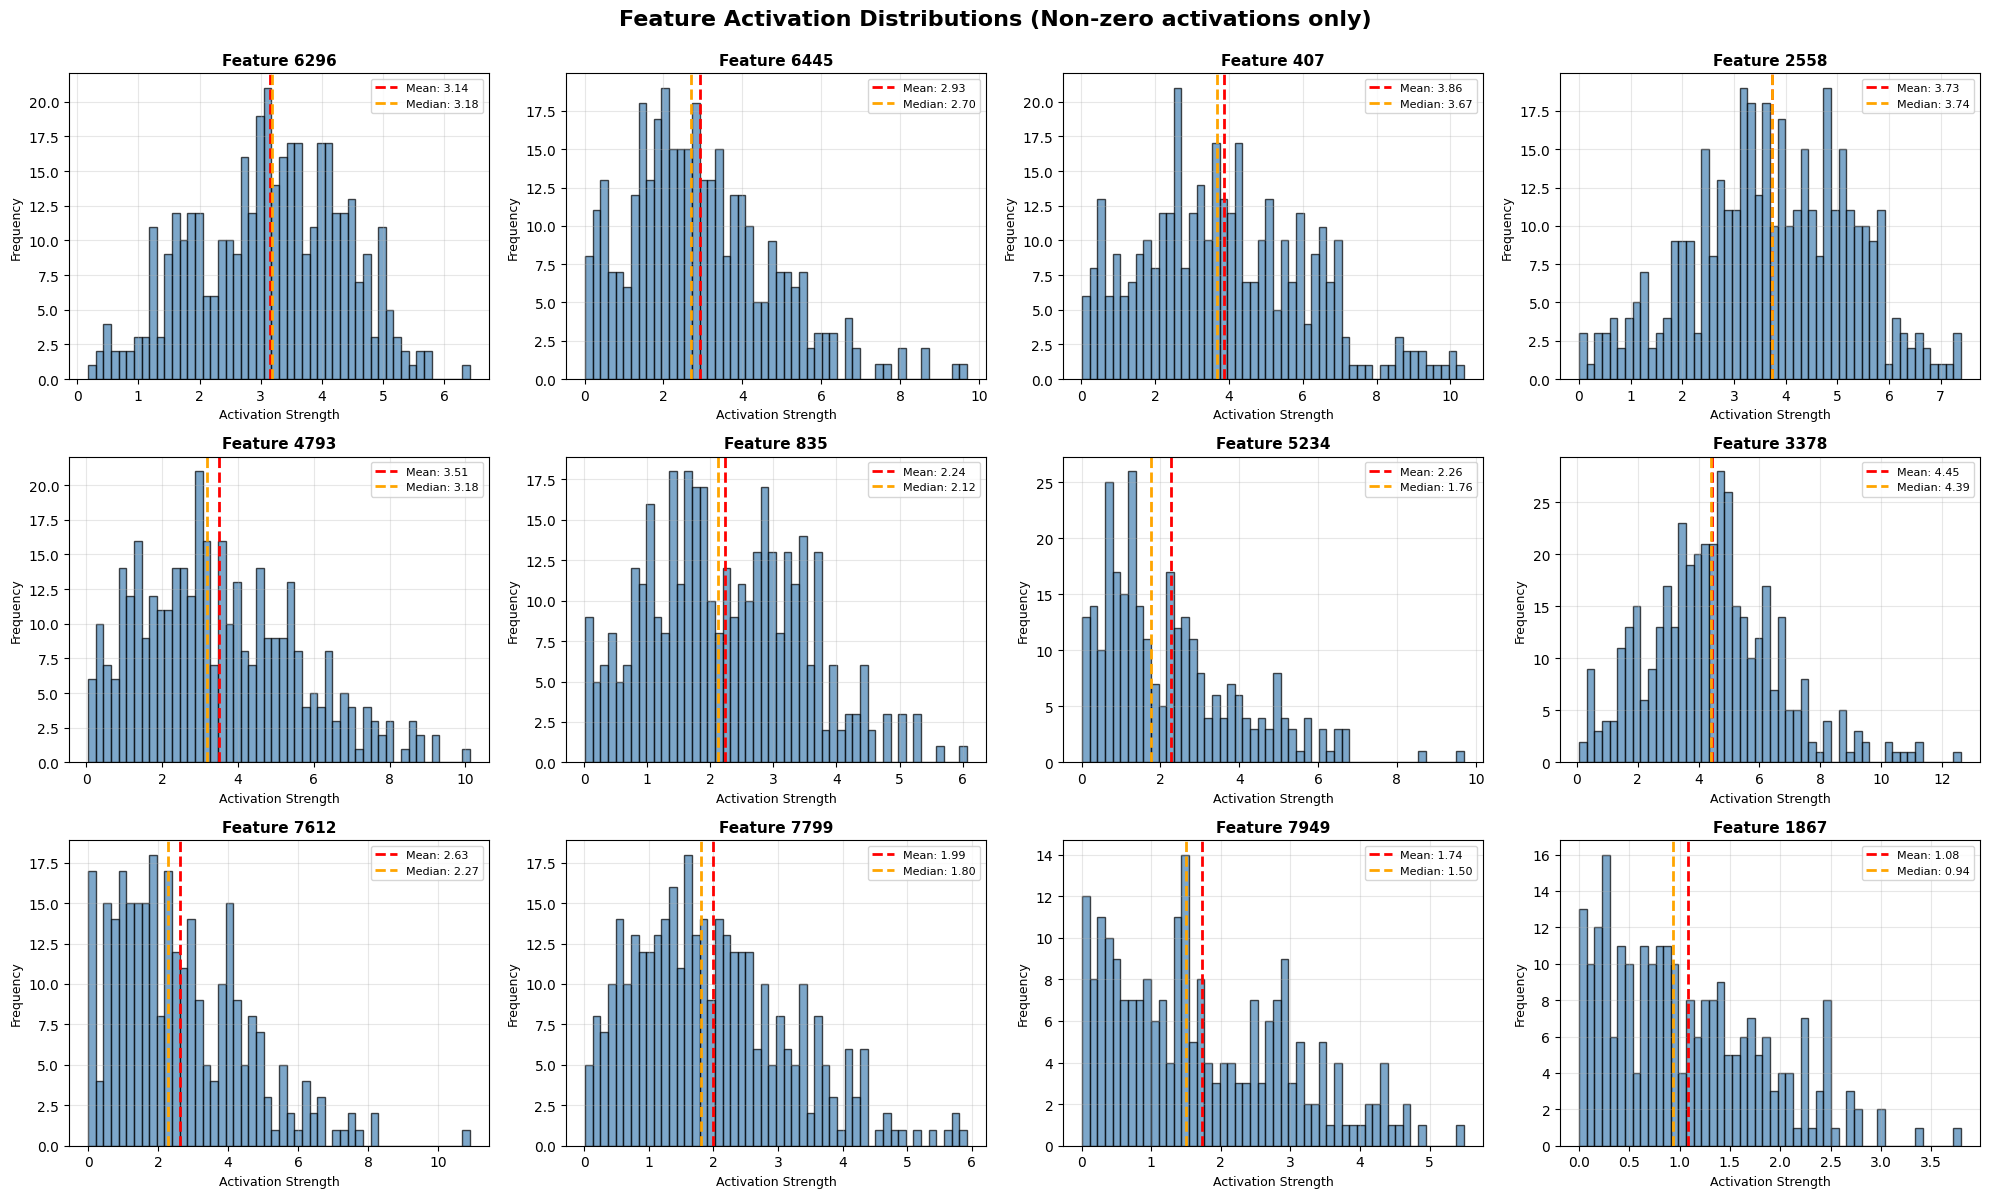

Distribution plot saved to data/feature_activation_distributions.png


In [10]:
def plot_activation_distributions(feature_activations, feature_ids, output_path):
    """
    Plot histogram distributions of feature activations.
    
    Args:
        feature_activations: Dict mapping feature_id to list of activation arrays
        feature_ids: List of feature IDs to plot
        output_path: Path to save the figure
    """
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, feat_id in enumerate(feature_ids):
        ax = axes[idx]
        
        # Collect all non-zero activations for this feature
        all_activations = np.concatenate(feature_activations[feat_id])
        non_zero_acts = all_activations[all_activations > 0]
        
        if len(non_zero_acts) > 0:
            ax.hist(non_zero_acts, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            ax.axvline(np.mean(non_zero_acts), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {np.mean(non_zero_acts):.2f}')
            ax.axvline(np.median(non_zero_acts), color='orange', linestyle='--', 
                       linewidth=2, label=f'Median: {np.median(non_zero_acts):.2f}')
            ax.legend(fontsize=8)
        
        ax.set_title(f'Feature {feat_id}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Activation Strength', fontsize=9)
        ax.set_ylabel('Frequency', fontsize=9)
        ax.grid(alpha=0.3)
    
    plt.suptitle('Feature Activation Distributions (Non-zero activations only)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Distribution plot saved to {output_path}")


# Generate distribution plots
plot_activation_distributions(feature_activations, target_features, 
                              'data/feature_activation_distributions.png')


In [11]:
def compute_feature_statistics(feature_activations, feature_ids):
    """
    Compute summary statistics for each feature's activations.
    
    Args:
        feature_activations: Dict mapping feature_id to list of activation arrays
        feature_ids: List of feature IDs to analyze
        
    Returns:
        pd.DataFrame: Statistics for each feature
    """
    stats_data = []
    for feat_id in feature_ids:
        all_activations = np.concatenate(feature_activations[feat_id])
        stats_data.append({
            'Feature': feat_id,
            'Max': np.max(all_activations),
            'Mean': np.mean(all_activations),
            'Std': np.std(all_activations),
            'Median': np.median(all_activations),
            '95th %ile': np.percentile(all_activations, 95),
            'Non-zero %': 100 * np.mean(all_activations > 0)
        })
    
    stats_df = pd.DataFrame(stats_data)
    stats_df = stats_df.sort_values('Max', ascending=False)
    return stats_df


# Compute and display statistics
print("\n" + "="*80)
print("FEATURE ACTIVATION STATISTICS")
print("="*80)

stats_df = compute_feature_statistics(feature_activations, target_features)
print(stats_df.to_string(index=False))
print("\n")

# Save statistics to CSV
stats_df.to_csv('data/feature_activation_stats.csv', index=False)
print("Statistics saved to data/feature_activation_stats.csv")



FEATURE ACTIVATION STATISTICS
 Feature       Max     Mean      Std   Median  95th %ile  Non-zero %
    3378 12.615613 4.343603 2.203887 4.311027   8.219373   97.619048
    7612 10.896579 1.835305 1.967204 1.319849   5.648703   69.761905
     407 10.364836 3.354075 2.451406 3.249032   7.095263   86.904762
    4793 10.119128 3.082245 2.270736 2.909637   7.129512   87.857143
    5234  9.698924 1.568203 1.779613 1.026872   5.147190   69.285714
    6445  9.696674 2.427695 1.978741 2.240891   5.948755   82.857143
    2558  7.391453 3.512432 1.718119 3.629707   5.889570   94.047619
    6296  6.419417 2.980118 1.355789 3.105639   4.966948   94.761905
     835  6.066607 2.018350 1.329149 1.929397   4.278946   90.238095
    7799  5.926148 1.687813 1.321640 1.565506   4.135638   85.000000
    7949  5.489678 0.934086 1.266166 0.167980   3.580507   53.809524
    1867  3.795671 0.650579 0.802539 0.283618   2.333279   60.238095


Statistics saved to data/feature_activation_stats.csv


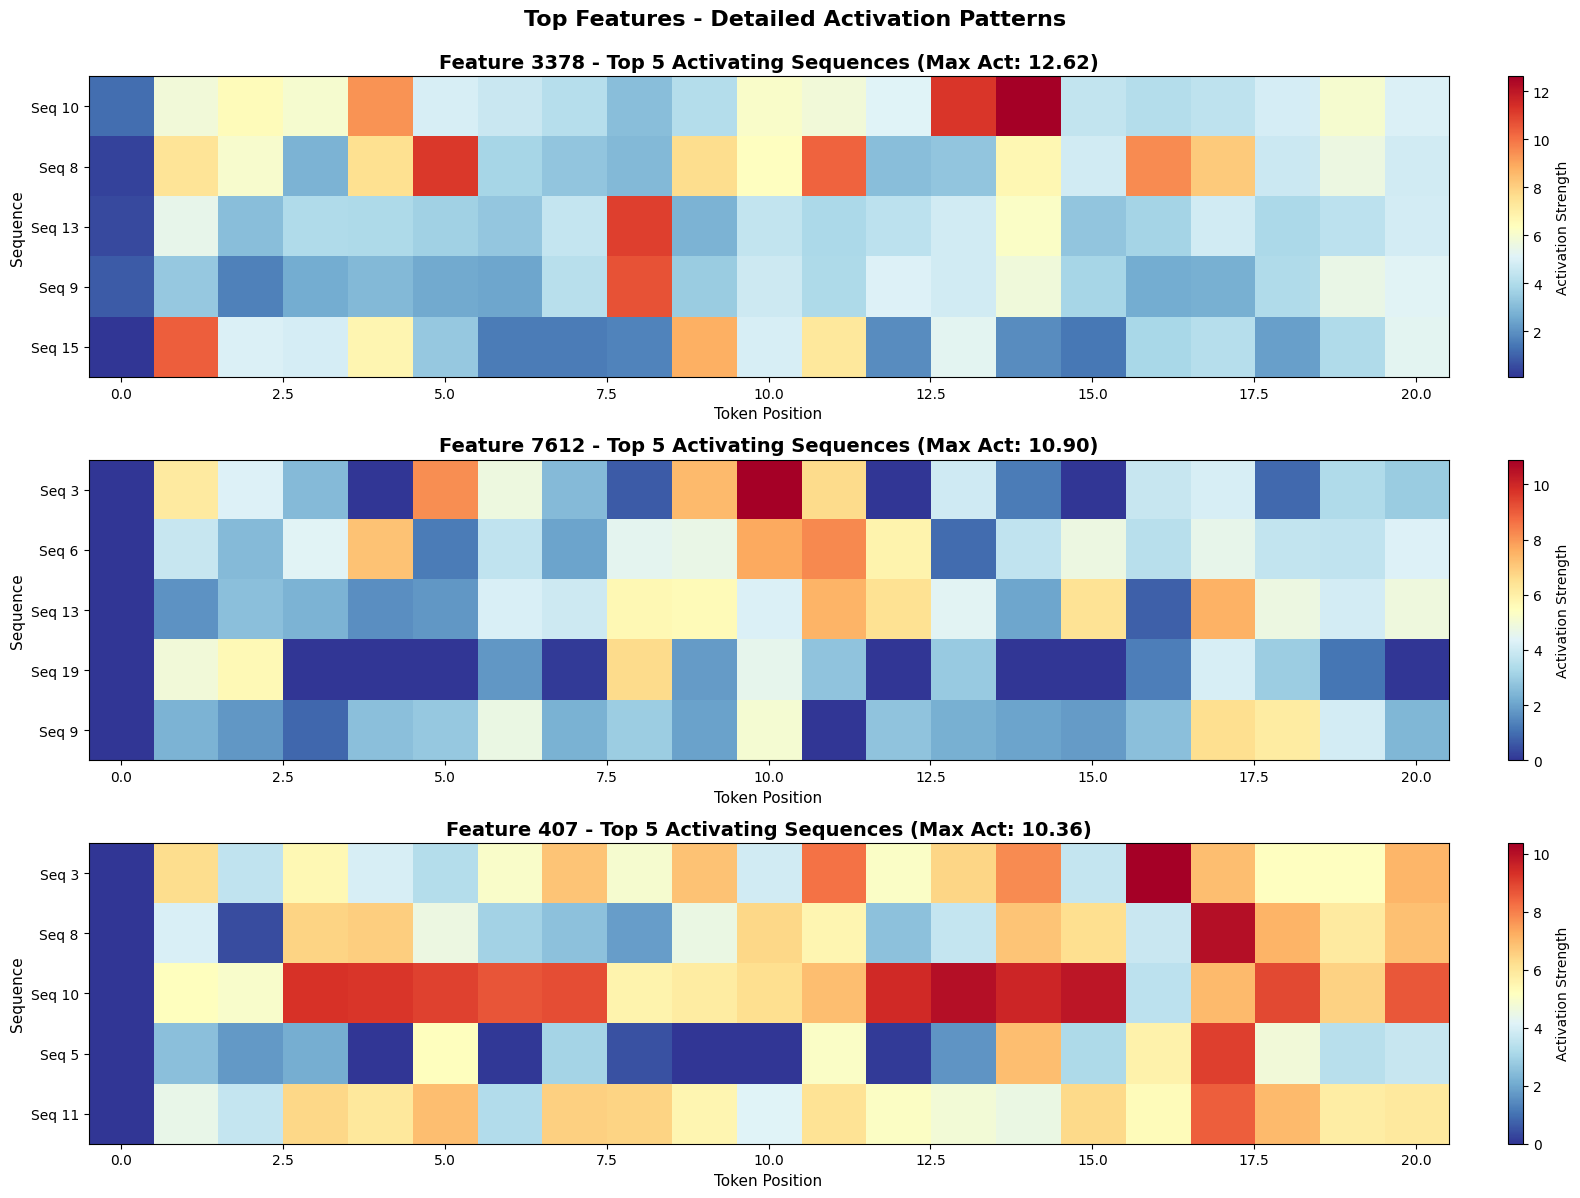

Top features detailed plot saved to data/top_features_detailed.png


In [12]:
def plot_top_features_detailed(feature_activations, feature_ids, top_n=3, top_seqs=5, output_path='data/top_features_detailed.png'):
    """
    Create detailed plots for the most strongly activating features.
    
    Args:
        feature_activations: Dict mapping feature_id to list of activation arrays
        feature_ids: List of feature IDs to analyze
        top_n: Number of top features to plot
        top_seqs: Number of top sequences to show per feature
        output_path: Path to save the figure
    """
    # Find features with highest max activations
    feature_max_activations = {
        feat_id: max(np.max(acts) for acts in feature_activations[feat_id])
        for feat_id in feature_ids
    }
    top_features = sorted(feature_max_activations.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Determine max sequence length across all features
    max_len = max(
        max(len(acts) for acts in feature_activations[feat_id])
        for feat_id in feature_ids
    )
    
    fig, axes = plt.subplots(len(top_features), 1, figsize=(16, 4*len(top_features)))
    if len(top_features) == 1:
        axes = [axes]
    
    for idx, (feat_id, max_act) in enumerate(top_features):
        ax = axes[idx]
        
        # Find sequences with highest activation for this feature
        seq_max_activations = [(i, np.max(acts)) for i, acts in enumerate(feature_activations[feat_id])]
        top_seq_indices = sorted(seq_max_activations, key=lambda x: x[1], reverse=True)[:top_seqs]
        
        # Plot only the top sequences for this feature
        activation_matrix = np.zeros((top_seqs, max_len))
        seq_labels = []
        
        for plot_idx, (seq_idx, _) in enumerate(top_seq_indices):
            acts = feature_activations[feat_id][seq_idx]
            activation_matrix[plot_idx, :len(acts)] = acts
            seq_labels.append(f"Seq {seq_idx}")
        
        im = ax.imshow(activation_matrix, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
        ax.set_title(f'Feature {feat_id} - Top {top_seqs} Activating Sequences (Max Act: {max_act:.2f})', 
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('Token Position', fontsize=11)
        ax.set_ylabel('Sequence', fontsize=11)
        ax.set_yticks(range(top_seqs))
        ax.set_yticklabels(seq_labels)
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Activation Strength')
    
    plt.suptitle('Top Features - Detailed Activation Patterns', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Top features detailed plot saved to {output_path}")


# Generate detailed plots for top features
plot_top_features_detailed(feature_activations, target_features)


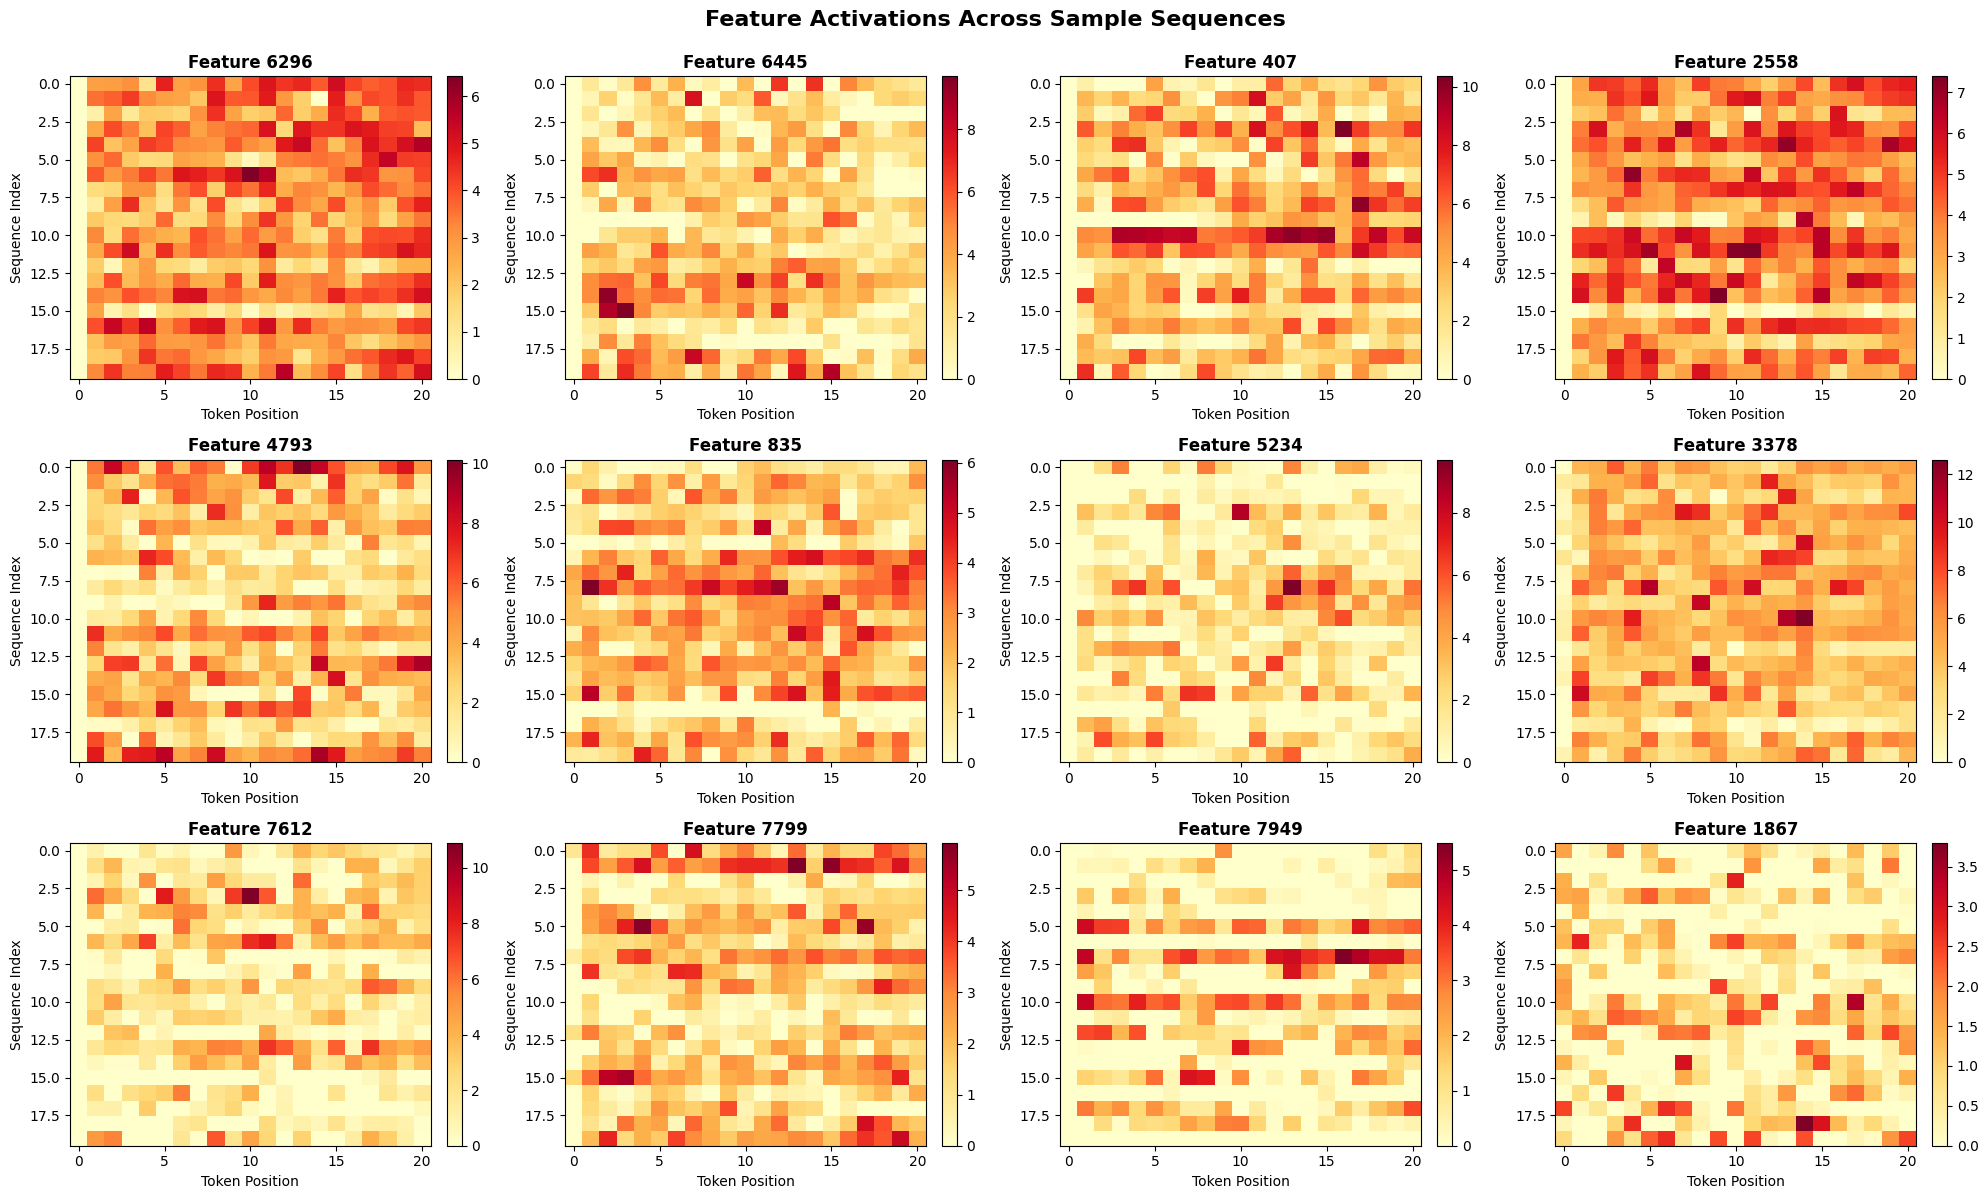

Heatmap visualization saved to data/feature_activation_heatmaps.png


In [13]:
def plot_feature_heatmaps(feature_activations, feature_ids, num_sequences, output_path):
    """
    Create a grid of heatmaps showing feature activations across sequences.
    
    Args:
        feature_activations: Dict mapping feature_id to list of activation arrays
        feature_ids: List of feature IDs to plot
        num_sequences: Number of sequences analyzed
        output_path: Path to save the figure
    """
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, feat_id in enumerate(feature_ids):
        ax = axes[idx]
        
        # Stack activations into a matrix (sequences x positions)
        max_len = max(len(acts) for acts in feature_activations[feat_id])
        activation_matrix = np.zeros((num_sequences, max_len))
        
        for seq_idx, acts in enumerate(feature_activations[feat_id]):
            activation_matrix[seq_idx, :len(acts)] = acts
        
        # Create heatmap
        im = ax.imshow(activation_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
        ax.set_title(f'Feature {feat_id}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Token Position', fontsize=10)
        ax.set_ylabel('Sequence Index', fontsize=10)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.suptitle('Feature Activations Across Sample Sequences', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Heatmap visualization saved to {output_path}")


# Generate the heatmap grid
plot_feature_heatmaps(feature_activations, target_features, len(sample_seqs), 
                      'data/feature_activation_heatmaps.png')
